## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from nltk.stem.snowball import SnowballStemmer 
import re
from copy import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
import scipy.stats as st
from sklearn.metrics import recall_score


tqdm.pandas()
stemmer = SnowballStemmer("russian") 
%matplotlib inline

In [2]:
df_train = pd.read_csv("train_dataset_train.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

## Рассмотрим датасет поближе

In [3]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


In [4]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [5]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


In [6]:
df_log

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах
...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ


In [7]:
df_log['event_type'].value_counts()

Информер ВК. Показ                                                  8001
Включение интернета на 20 минут                                     4092
Обращение в службу заботы о клиентах                                2860
Гарантированный платеж за деньги                                    2679
Виртуальное бессмертие. Использование                                757
                                                                    ... 
Футболка Ситилинк                                                      1
Закрытие информатора об изменении уведомлений через ВК платформу       1
Окончание рассрочки за подключение                                     1
Общий счет. Отсоединение реципиента                                    1
Общий счет. Отсоединение от донора                                     1
Name: event_type, Length: 105, dtype: int64

In [8]:
df_named['contract_id'].value_counts()

14321    6934
31215    6902
12914    6632
27891    6491
54140    3675
         ... 
10363       1
31238       1
34688       1
51415       1
48679       1
Name: contract_id, Length: 196148, dtype: int64

Узнаем размерность наборов

In [9]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 3)


## Видоизмение данных

In [10]:
df_named['day'] = df_named['date'].apply(lambda x: int(x[0:2])) + 31*df_named['date'].apply(lambda x: int(x[3:6] == 'Apr'))
df_named.head(3)

,date,url,contract_id,day
0,17-Apr-2021,webmail.sampo.ru,101397,48
1,17-Apr-2021,webmail.sampo.ru,179624,48
2,17-Apr-2021,tvip-provision.sampo.ru,190335,48


In [11]:
df_named['url'] = df_named['url'].apply(lambda x: '.'.join(x.split('.')[-2:]))

In [12]:
df_named.head(3)

,date,url,contract_id,day
0,17-Apr-2021,sampo.ru,101397,48
1,17-Apr-2021,sampo.ru,179624,48
2,17-Apr-2021,sampo.ru,190335,48


In [13]:
df_log['time'] = df_log['event_date'].apply(lambda x: (float(x[-8:-6]) + (float(x[-5:-3]) + float(x[-2:])/60)/60)/24)
df_log['time_X'] = df_log['time'].apply(lambda x: np.cos(2*np.pi*x))
df_log['time_Y'] = df_log['time'].apply(lambda x: np.sin(2*np.pi*x))
df_log['day'] = df_log['event_date'].apply(lambda x: float(x[8:10])) + 31.0*df_log['event_date'].apply(lambda x: int(x[7]==4)) + df_log['time']
df_log = df_log.drop(columns = ['event_date', 'time'])

In [14]:
df_log

,contract_id,event_type,time_X,time_Y,day
0,36294,Добавление в Обращались с номеров,-0.404743,-0.914431,28.683681
1,36294,Обращение в службу заботы о клиентах,-0.392003,-0.919964,28.685891
2,36294,Выключение IPTV-пакета,-0.382952,-0.923768,28.687454
3,36294,Включение IPTV-пакета,-0.382952,-0.923768,28.687454
4,36294,Обращение в службу заботы о клиентах,-0.362167,-0.932113,28.691019
...,...,...,...,...,...
25269,11801,Информер ВК. Показ,-0.464584,0.885529,29.326898
25270,54405,Информер ВК. Показ,-0.937737,0.347345,17.443542
25271,54405,Информер ВК. Показ,-0.578866,0.815423,23.348252
25272,54405,Информер ВК. Показ,-0.960739,-0.277454,9.544745


## Аггрегирование данных

In [15]:
def aggregate_stats(df, target_column, ignore=[], category=[], df_name=''):
    agg = pd.concat([df.drop(columns=ignore+category).groupby(by=target_column).agg(['mean', 'std', 
                                                                'median', 'min', 
                                                                'max', 'skew']).fillna(-1)] + \
                     [pd.crosstab(df[target_column], df[category_column]) for category_column in category] + 
                     [df.drop(columns=ignore).groupby(by=[target_column]+category).agg(['mean', 'std', 
                                      'median', 'min', 
                                      'max', 'skew']).unstack(list(range(-len(category), 0))).fillna(-1)], axis=1)
    agg['n_data_'+df_name] = pd.Series(Counter(df[target_column]))
    return agg

In [16]:
df_named_agg = aggregate_stats(df_named.drop(columns=['date']), 
                               'contract_id', category=['url'], df_name='named')

In [17]:
df_named_agg

,"(day, mean)","(day, std)","(day, median)","(day, min)","(day, max)","(day, skew)",SERVICE.local,citylink-rk.ru,dkimwl.org,geo.krc,...,"(day, skew, ru.netis)","(day, skew, rua.rude)","(day, skew, sampo.ru)","(day, skew, sampo.ru/movie)","(day, skew, sampo.rueniede)","(day, skew, sampo.ruhttps)","(day, skew, spamhaus.org)","(day, skew, tendawifi.com)","(day, skew, zvelo.com)",n_data_named
contract_id,,,,,,,,,,,,,,,,,,,,,
3455,46.708333,9.153185,41.0,32,59,0.336200,0,0,0,0,...,-1.0,-1.0,-0.132425,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24
3458,51.000000,-1.000000,51.0,51,51,-1.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3459,59.000000,0.000000,59.0,59,59,-1.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
3460,28.600000,1.264911,28.0,28,31,1.778781,0,0,0,0,...,-1.0,-1.0,1.778781,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10
3461,48.000000,-1.000000,48.0,48,48,-1.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271820,30.000000,0.000000,30.0,30,30,-1.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
272061,35.000000,0.000000,35.0,35,35,0.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5
273472,28.000000,-1.000000,28.0,28,28,-1.000000,0,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


In [18]:
df_named_agg.to_csv('named_agg.csv')

In [19]:
df_log_agg = aggregate_stats(df_log, 
                               'contract_id', category=['event_type'], df_name='log')

In [20]:
df_log_agg

,"(time_X, mean)","(time_X, std)","(time_X, median)","(time_X, min)","(time_X, max)","(time_X, skew)","(time_Y, mean)","(time_Y, std)","(time_Y, median)","(time_Y, min)",...,"(day, skew, Турбокнопка платно (1 час))","(day, skew, Уведомления: отключение)","(day, skew, Уведомления: подключение)","(day, skew, Уведомления: подтверждение)","(day, skew, Удаление ip-адреса)","(day, skew, Удаление из Обращались с номеров)","(day, skew, Удаление телефона из записи)","(day, skew, Футболка Ситилинк)","(day, skew, Чек лист выполненных работ при регистрации)",n_data_log
contract_id,,,,,,,,,,,,,,,,,,,,,
3453,-0.426700,-1.000000,-0.426700,-0.426700,-0.426700,-1.000000,-0.904393,-1.000000,-0.904393,-0.904393,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3454,-0.990689,-1.000000,-0.990689,-0.990689,-0.990689,-1.000000,0.136148,-1.000000,0.136148,0.136148,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3456,0.331025,0.012289,0.324880,0.324880,0.349458,2.000000,-0.943554,0.004402,-0.945755,-0.945755,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
3457,0.236320,0.597211,0.484813,-0.646290,0.621945,-1.832609,-0.438765,0.803444,-0.798229,-0.921694,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
3458,0.121458,0.612803,0.121075,-0.999888,0.989378,-0.060990,-0.520442,0.609371,-0.820193,-0.998240,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274601,-0.927016,0.060480,-0.951135,-0.959540,-0.803943,2.415303,0.156590,0.368359,0.307460,-0.594706,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6
274710,0.359681,0.150726,0.446783,0.135644,0.449189,-1.230199,-0.921557,0.046948,-0.894642,-0.990758,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7
274782,-0.962978,0.015899,-0.960608,-0.987677,-0.932403,0.516494,-0.015168,0.287298,-0.060614,-0.279550,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8


In [21]:
df_log_agg.to_csv('log_agg.csv')

## Обьединим четыре набора с данными

In [22]:
df_train = pd.merge(df_train, df_type_contract , 
                    on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_train

,contract_id,blocked,day_or_month_contract
0,7780,0,0.0
1,7785,0,0.0
2,7794,0,0.0
3,7795,0,1.0
4,7798,0,0.0
...,...,...,...
5988,274601,1,1.0
5989,274710,1,0.0
5990,274782,1,0.0
5991,274786,1,1.0


In [23]:
df_log_agg = pd.read_csv('log_agg.csv')
df_log_agg

,contract_id,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')","('time_Y', 'std')","('time_Y', 'median')",...,"('day', 'skew', 'Турбокнопка платно (1 час)')","('day', 'skew', 'Уведомления: отключение')","('day', 'skew', 'Уведомления: подключение')","('day', 'skew', 'Уведомления: подтверждение')","('day', 'skew', 'Удаление ip-адреса')","('day', 'skew', 'Удаление из Обращались с номеров')","('day', 'skew', 'Удаление телефона из записи')","('day', 'skew', 'Футболка Ситилинк')","('day', 'skew', 'Чек лист выполненных работ при регистрации')",n_data_log
0,3453,-0.426700,-1.000000,-0.426700,-0.426700,-0.426700,-1.000000,-0.904393,-1.000000,-0.904393,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,3454,-0.990689,-1.000000,-0.990689,-0.990689,-0.990689,-1.000000,0.136148,-1.000000,0.136148,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3456,0.331025,0.012289,0.324880,0.324880,0.349458,2.000000,-0.943554,0.004402,-0.945755,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
3,3457,0.236320,0.597211,0.484813,-0.646290,0.621945,-1.832609,-0.438765,0.803444,-0.798229,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
4,3458,0.121458,0.612803,0.121075,-0.999888,0.989378,-0.060990,-0.520442,0.609371,-0.820193,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,274601,-0.927016,0.060480,-0.951135,-0.959540,-0.803943,2.415303,0.156590,0.368359,0.307460,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6
4307,274710,0.359681,0.150726,0.446783,0.135644,0.449189,-1.230199,-0.921557,0.046948,-0.894642,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7
4308,274782,-0.962978,0.015899,-0.960608,-0.987677,-0.932403,0.516494,-0.015168,0.287298,-0.060614,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8
4309,274786,-0.297247,0.731121,-0.883834,-0.977216,0.586726,0.298132,-0.166805,0.678056,0.212249,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9


In [24]:
tmp = list(df_log_agg.columns)
tmp[0] = 'contract_id'
df_log_agg.columns = tmp

In [25]:
df_log_agg['contract_id'] = df_log_agg['contract_id'].astype(int)
df_log_agg

,contract_id,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')","('time_Y', 'std')","('time_Y', 'median')",...,"('day', 'skew', 'Турбокнопка платно (1 час)')","('day', 'skew', 'Уведомления: отключение')","('day', 'skew', 'Уведомления: подключение')","('day', 'skew', 'Уведомления: подтверждение')","('day', 'skew', 'Удаление ip-адреса')","('day', 'skew', 'Удаление из Обращались с номеров')","('day', 'skew', 'Удаление телефона из записи')","('day', 'skew', 'Футболка Ситилинк')","('day', 'skew', 'Чек лист выполненных работ при регистрации')",n_data_log
0,3453,-0.426700,-1.000000,-0.426700,-0.426700,-0.426700,-1.000000,-0.904393,-1.000000,-0.904393,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,3454,-0.990689,-1.000000,-0.990689,-0.990689,-0.990689,-1.000000,0.136148,-1.000000,0.136148,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3456,0.331025,0.012289,0.324880,0.324880,0.349458,2.000000,-0.943554,0.004402,-0.945755,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
3,3457,0.236320,0.597211,0.484813,-0.646290,0.621945,-1.832609,-0.438765,0.803444,-0.798229,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
4,3458,0.121458,0.612803,0.121075,-0.999888,0.989378,-0.060990,-0.520442,0.609371,-0.820193,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,274601,-0.927016,0.060480,-0.951135,-0.959540,-0.803943,2.415303,0.156590,0.368359,0.307460,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6
4307,274710,0.359681,0.150726,0.446783,0.135644,0.449189,-1.230199,-0.921557,0.046948,-0.894642,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7
4308,274782,-0.962978,0.015899,-0.960608,-0.987677,-0.932403,0.516494,-0.015168,0.287298,-0.060614,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8
4309,274786,-0.297247,0.731121,-0.883834,-0.977216,0.586726,0.298132,-0.166805,0.678056,0.212249,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9


In [26]:
df_train = pd.merge(df_train, df_log_agg , 
                    on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_train

,contract_id,blocked,day_or_month_contract,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')",...,"('day', 'skew', 'Турбокнопка платно (1 час)')","('day', 'skew', 'Уведомления: отключение')","('day', 'skew', 'Уведомления: подключение')","('day', 'skew', 'Уведомления: подтверждение')","('day', 'skew', 'Удаление ip-адреса')","('day', 'skew', 'Удаление из Обращались с номеров')","('day', 'skew', 'Удаление телефона из записи')","('day', 'skew', 'Футболка Ситилинк')","('day', 'skew', 'Чек лист выполненных работ при регистрации')",n_data_log
0,7780,0,0.0,-0.680691,0.145741,-0.602280,-0.936239,-0.578629,-1.511430,-0.537558,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0
1,7785,0,0.0,0.094470,-1.000000,0.094470,0.094470,0.094470,-1.000000,-0.995528,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7795,0,1.0,0.980035,0.017833,0.987043,0.947047,0.996370,-1.138460,-0.181449,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0
4,7798,0,0.0,-0.479266,0.871473,-0.968329,-0.996364,0.526894,1.730035,-0.394935,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,274601,1,1.0,-0.927016,0.060480,-0.951135,-0.959540,-0.803943,2.415303,0.156590,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
5988,274710,1,0.0,0.359681,0.150726,0.446783,0.135644,0.449189,-1.230199,-0.921557,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0
5989,274782,1,0.0,-0.962978,0.015899,-0.960608,-0.987677,-0.932403,0.516494,-0.015168,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0
5990,274786,1,1.0,-0.297247,0.731121,-0.883834,-0.977216,0.586726,0.298132,-0.166805,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0


In [27]:
df_named_agg = pd.read_csv('named_agg.csv')
df_named_agg

,contract_id,"('day', 'mean')","('day', 'std')","('day', 'median')","('day', 'min')","('day', 'max')","('day', 'skew')",SERVICE.local,citylink-rk.ru,dkimwl.org,...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
0,3455,46.708333,9.153185,41.0,32,59,0.336200,0,0,0,...,-1.0,-1.0,-0.132425,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24
1,3458,51.000000,-1.000000,51.0,51,51,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3459,59.000000,0.000000,59.0,59,59,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
3,3460,28.600000,1.264911,28.0,28,31,1.778781,0,0,0,...,-1.0,-1.0,1.778781,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10
4,3461,48.000000,-1.000000,48.0,48,48,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196143,271820,30.000000,0.000000,30.0,30,30,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
196144,272061,35.000000,0.000000,35.0,35,35,0.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5
196145,273472,28.000000,-1.000000,28.0,28,28,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
196146,273538,48.200000,1.643168,47.0,47,50,0.608581,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5


In [28]:
tmp = list(df_named_agg.columns)
tmp[0] = 'contract_id'
df_named_agg.columns = tmp

In [29]:
df_named_agg['contract_id'] = df_named_agg['contract_id'].astype(int)
df_named_agg

,contract_id,"('day', 'mean')","('day', 'std')","('day', 'median')","('day', 'min')","('day', 'max')","('day', 'skew')",SERVICE.local,citylink-rk.ru,dkimwl.org,...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
0,3455,46.708333,9.153185,41.0,32,59,0.336200,0,0,0,...,-1.0,-1.0,-0.132425,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24
1,3458,51.000000,-1.000000,51.0,51,51,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3459,59.000000,0.000000,59.0,59,59,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
3,3460,28.600000,1.264911,28.0,28,31,1.778781,0,0,0,...,-1.0,-1.0,1.778781,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10
4,3461,48.000000,-1.000000,48.0,48,48,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196143,271820,30.000000,0.000000,30.0,30,30,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
196144,272061,35.000000,0.000000,35.0,35,35,0.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5
196145,273472,28.000000,-1.000000,28.0,28,28,-1.000000,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
196146,273538,48.200000,1.643168,47.0,47,50,0.608581,0,0,0,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5


In [30]:
df_train = pd.merge(df_train, df_named_agg , on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_train

,contract_id,blocked,day_or_month_contract,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')",...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
0,7780,0,0.0,-0.680691,0.145741,-0.602280,-0.936239,-0.578629,-1.511430,-0.537558,...,-1.0,-1.0,-0.374296,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,83.0
1,7785,0,0.0,0.094470,-1.000000,0.094470,0.094470,0.094470,-1.000000,-0.995528,...,-1.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10.0
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7795,0,1.0,0.980035,0.017833,0.987043,0.947047,0.996370,-1.138460,-0.181449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7798,0,0.0,-0.479266,0.871473,-0.968329,-0.996364,0.526894,1.730035,-0.394935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,274601,1,1.0,-0.927016,0.060480,-0.951135,-0.959540,-0.803943,2.415303,0.156590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5988,274710,1,0.0,0.359681,0.150726,0.446783,0.135644,0.449189,-1.230199,-0.921557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5989,274782,1,0.0,-0.962978,0.015899,-0.960608,-0.987677,-0.932403,0.516494,-0.015168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5990,274786,1,1.0,-0.297247,0.731121,-0.883834,-0.977216,0.586726,0.298132,-0.166805,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [31]:
df_train = df_train.fillna(-2)

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Columns: 2213 entries, contract_id to n_data_named
dtypes: float64(2211), int64(2)
memory usage: 101.2 MB


In [33]:
df_train.head()

,contract_id,blocked,day_or_month_contract,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')",...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
0,7780,0,0.0,-0.680691,0.145741,-0.602280,-0.936239,-0.578629,-1.511430,-0.537558,...,-1.0,-1.0,-0.374296,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,83.0
1,7785,0,0.0,0.094470,-1.000000,0.094470,0.094470,0.094470,-1.000000,-0.995528,...,-1.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10.0
2,7794,0,0.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,7795,0,1.0,0.980035,0.017833,0.987043,0.947047,0.996370,-1.138460,-0.181449,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,7798,0,0.0,-0.479266,0.871473,-0.968329,-0.996364,0.526894,1.730035,-0.394935,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


## Выделим выборки

In [34]:
X = df_train.drop(["contract_id", "blocked"], axis = 1)
y = df_train["blocked"]

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Columns: 2211 entries, day_or_month_contract to n_data_named
dtypes: float64(2211)
memory usage: 101.1 MB


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

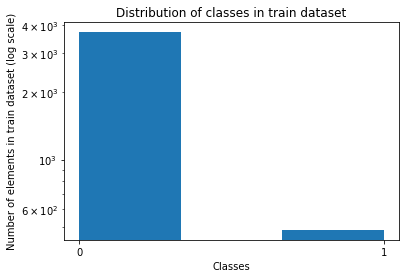

In [52]:
plt.hist(y_train, 3)
plt.title('Distribution of classes in train dataset')
plt.yscale('log')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Classes')
plt.xticks([0, 1])
plt.show()

In [38]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5653815044486384, 1: 4.323711340206185}

## Обучение модели

In [39]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'custom_metric':'Recall',
          'class_weights': class_weights,
          'verbose': 200,
          'random_seed': 0,
          'iterations': 1000,
          'depth': 3
         }
model = CatBoostClassifier(**params)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111117
0:	learn: 0.6460966	test: 0.6907597	best: 0.6907597 (0)	total: 91.8ms	remaining: 1m 31s
200:	learn: 0.7749971	test: 0.6880918	best: 0.7281720 (46)	total: 2.63s	remaining: 10.4s
400:	learn: 0.8194360	test: 0.6789056	best: 0.7281720 (46)	total: 5.15s	remaining: 7.7s
600:	learn: 0.8409009	test: 0.6546652	best: 0.7281720 (46)	total: 7.67s	remaining: 5.09s
800:	learn: 0.8523904	test: 0.6514594	best: 0.7281720 (46)	total: 10.3s	remaining: 2.56s
999:	learn: 0.8616693	test: 0.6389098	best: 0.7281720 (46)	total: 12.9s	remaining: 0us

bestTest = 0.7281719577
bestIteration = 46

Shrink model to first 47 iterations.


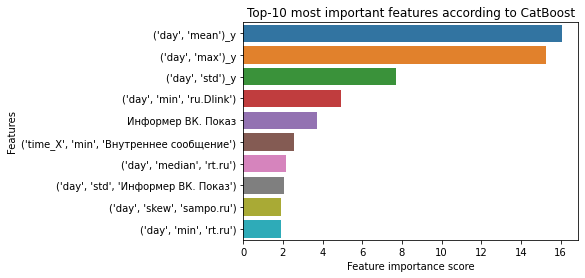

In [40]:
feature_importance = model.get_feature_importance()
feature_ranks = feature_importance.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks[:10]],x=feature_importance[feature_ranks[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

## Проверка качества

In [41]:
pred = model.predict(X_test)

In [42]:
y_test.value_counts()

0    1585
1     213
Name: blocked, dtype: int64

In [43]:
Counter(pred.flatten())

Counter({0: 1213, 1: 585})

In [44]:
print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.7282030775610551


## Предсказание для тестовых данных

In [45]:
df_test = pd.read_csv("sample_solution.csv")

In [46]:
df_test

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


In [47]:
df_test = pd.merge(df_test, df_type_contract, on="contract_id", how='left')
df_test = pd.merge(df_test, df_log_agg, on="contract_id", how='left')
df_test = pd.merge(df_test, df_named_agg, on="contract_id", how='left')
df_test.dropna()

,contract_id,blocked,day_or_month_contract,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')",...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
5,3458,0,0,0.121458,0.612803,0.121075,-0.999888,0.989378,-0.060990,-0.520442,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
6,3459,0,0,-0.234810,0.789274,-0.462169,-0.972658,0.724072,0.536855,-0.598772,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
7,3460,0,0,0.664796,-1.000000,0.664796,0.664796,0.664796,-1.000000,-0.747025,...,-1.0,-1.0,1.778781,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10.0
12,3465,0,0,-0.437752,0.119336,-0.392570,-0.603498,-0.188953,0.251870,-0.890031,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
15,3468,0,0,0.165470,0.688396,0.338259,-0.562083,0.805239,-0.301429,-0.094558,...,-1.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,4243,0,0,0.393975,0.000236,0.393975,0.393808,0.394142,-1.000000,-0.919121,...,-1.0,-1.0,0.608581,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
797,4246,0,1,-0.366087,0.342129,-0.213741,-0.978102,-0.211112,-2.236006,-0.740002,...,-1.0,-1.0,-0.564445,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,271.0
799,4248,0,1,-0.111525,0.799195,-0.193164,-0.994567,0.992260,0.087549,-0.134394,...,-1.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10.0
804,4253,0,1,0.688756,0.009307,0.684282,0.682530,0.699455,1.663266,-0.724917,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0


In [48]:
df_test = df_test.fillna(-2)
df_test

,contract_id,blocked,day_or_month_contract,"('time_X', 'mean')","('time_X', 'std')","('time_X', 'median')","('time_X', 'min')","('time_X', 'max')","('time_X', 'skew')","('time_Y', 'mean')",...,"('day', 'skew', 'ru.netis')","('day', 'skew', 'rua.rude')","('day', 'skew', 'sampo.ru')","('day', 'skew', 'sampo.ru/movie')","('day', 'skew', 'sampo.rueniede')","('day', 'skew', 'sampo.ruhttps')","('day', 'skew', 'spamhaus.org')","('day', 'skew', 'tendawifi.com')","('day', 'skew', 'zvelo.com')",n_data_named
0,3453,0,0,-0.426700,-1.000000,-0.426700,-0.426700,-0.426700,-1.000000,-0.904393,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,3454,0,1,-0.990689,-1.000000,-0.990689,-0.990689,-0.990689,-1.000000,0.136148,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,3455,0,1,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.0,-1.0,-0.132425,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24.0
3,3456,0,0,0.331025,0.012289,0.324880,0.324880,0.349458,2.000000,-0.943554,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,3457,0,0,0.236320,0.597211,0.484813,-0.646290,0.621945,-1.832609,-0.438765,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,4258,0,1,-0.870792,0.063436,-0.901487,-0.913042,-0.797847,1.667619,0.209267,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
810,4259,0,1,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.0,-1.0,-0.312574,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,484.0
811,4260,0,0,0.186275,0.889169,0.699611,-0.840448,0.699663,-1.732051,-0.656963,...,-1.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0
812,4261,0,0,-0.679054,0.237109,-0.709736,-0.999186,-0.396147,0.163139,-0.559968,...,-2.0,-2.0,-2.000000,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [49]:
df_test['blocked'] = model.predict(df_test.drop(columns=["contract_id", 'blocked']))

In [50]:
df_test['blocked'].value_counts()

0    555
1    259
Name: blocked, dtype: int64

In [51]:
df_test[['contract_id', 'blocked']].to_csv('submission.csv', index=False)